In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [3]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=512):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.fc_bn = nn.BatchNorm1d(512)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 7)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.fc_bn(out)
        return out

In [5]:
def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
net = ResNet50()
checkpoint = torch.load('/content/gdrive/My Drive/adv_att/best_model_chkpt-resnet50.t7')
net.load_state_dict(checkpoint['net'])


<All keys matched successfully>

In [8]:
#pair file FIVE!
import pytorch_ssim
from torch.autograd import Variable
from PIL import Image
import torchvision.transforms.functional as TF
from torch import optim
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from statistics import mean
import pandas as pd
from PIL import Image
img_path = '/content/gdrive/My Drive/adv_att/imgs/'
preprocess = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
pair_file_five = pd.read_csv('/content/gdrive/My Drive/adv_att/pairs_list7.csv',delimiter='|')
pair_file_five = img_path + pair_file_five.astype(str)
pair_file_five.head()

,source_imgs1,source_imgs2,source_imgs3,source_imgs4,source_imgs5,target_imgs1,target_imgs2,target_imgs3,target_imgs4,target_imgs5
0,/content/gdrive/My Drive/adv_att/imgs/60f5fb29...,/content/gdrive/My Drive/adv_att/imgs/bc01280f...,/content/gdrive/My Drive/adv_att/imgs/254a446a...,/content/gdrive/My Drive/adv_att/imgs/3a3a9ad1...,/content/gdrive/My Drive/adv_att/imgs/90f023cf...,/content/gdrive/My Drive/adv_att/imgs/48f9c10f...,/content/gdrive/My Drive/adv_att/imgs/22d25082...,/content/gdrive/My Drive/adv_att/imgs/92d8d230...,/content/gdrive/My Drive/adv_att/imgs/be1f554b...,/content/gdrive/My Drive/adv_att/imgs/dc758fdf...
1,/content/gdrive/My Drive/adv_att/imgs/3e15d19b...,/content/gdrive/My Drive/adv_att/imgs/902d7cb3...,/content/gdrive/My Drive/adv_att/imgs/fddf26e4...,/content/gdrive/My Drive/adv_att/imgs/62564b99...,/content/gdrive/My Drive/adv_att/imgs/d33d4395...,/content/gdrive/My Drive/adv_att/imgs/d53757cc...,/content/gdrive/My Drive/adv_att/imgs/d6bc0e3c...,/content/gdrive/My Drive/adv_att/imgs/ac458ad9...,/content/gdrive/My Drive/adv_att/imgs/84297baf...,/content/gdrive/My Drive/adv_att/imgs/672a161b...
2,/content/gdrive/My Drive/adv_att/imgs/2cf2e394...,/content/gdrive/My Drive/adv_att/imgs/2249d6d2...,/content/gdrive/My Drive/adv_att/imgs/a0e8e796...,/content/gdrive/My Drive/adv_att/imgs/fa15e057...,/content/gdrive/My Drive/adv_att/imgs/e7f233a0...,/content/gdrive/My Drive/adv_att/imgs/8f9faa11...,/content/gdrive/My Drive/adv_att/imgs/b9c6ea48...,/content/gdrive/My Drive/adv_att/imgs/1de4eb9d...,/content/gdrive/My Drive/adv_att/imgs/714fc3bf...,/content/gdrive/My Drive/adv_att/imgs/8bcae2dc...
3,/content/gdrive/My Drive/adv_att/imgs/dcf724de...,/content/gdrive/My Drive/adv_att/imgs/b223702e...,/content/gdrive/My Drive/adv_att/imgs/92b333e7...,/content/gdrive/My Drive/adv_att/imgs/e0fe6340...,/content/gdrive/My Drive/adv_att/imgs/c5816a41...,/content/gdrive/My Drive/adv_att/imgs/b57e0e26...,/content/gdrive/My Drive/adv_att/imgs/2eed2c66...,/content/gdrive/My Drive/adv_att/imgs/4b4ef883...,/content/gdrive/My Drive/adv_att/imgs/1f97a752...,/content/gdrive/My Drive/adv_att/imgs/ffd51611...
4,/content/gdrive/My Drive/adv_att/imgs/589b3c02...,/content/gdrive/My Drive/adv_att/imgs/575e6f5b...,/content/gdrive/My Drive/adv_att/imgs/022f5dec...,/content/gdrive/My Drive/adv_att/imgs/c4d612cb...,/content/gdrive/My Drive/adv_att/imgs/3fb81386...,/content/gdrive/My Drive/adv_att/imgs/76931fc5...,/content/gdrive/My Drive/adv_att/imgs/d4487b6e...,/content/gdrive/My Drive/adv_att/imgs/f99ccfc2...,/content/gdrive/My Drive/adv_att/imgs/4fd7c4bf...,/content/gdrive/My Drive/adv_att/imgs/2a65cd0d...


In [53]:
source_batch = pair_file_five.iloc[0,0:5]
target_batch = pair_file_five.iloc[0,5:]
print(target_batch)

target_imgs1    /content/gdrive/My Drive/adv_att/imgs/48f9c10f...
target_imgs2    /content/gdrive/My Drive/adv_att/imgs/22d25082...
target_imgs3    /content/gdrive/My Drive/adv_att/imgs/92d8d230...
target_imgs4    /content/gdrive/My Drive/adv_att/imgs/be1f554b...
target_imgs5    /content/gdrive/My Drive/adv_att/imgs/dc758fdf...
Name: 0, dtype: object


In [54]:
source_img_list = []
target_img_list = []
for elem in source_batch:
  img = Image.open(elem)
  peprs_img = preprocess(img)
  input_img = peprs_img.unsqueeze(0) 
  source_img_list.append(input_img)

for elem in target_batch:
  img = Image.open(elem)
  peprs_img = preprocess(img)
  input_img = peprs_img.unsqueeze(0) 
  target_img_list.append(input_img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

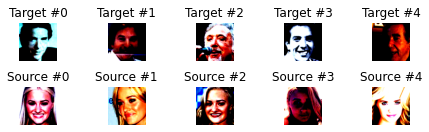

In [55]:
fig = plt.figure()
for i in range(len(source_img_list)):
    elem = source_img_list[i]
    target = target_img_list[i]
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    ax.set_title('Source #{}'.format(i))
    ax.axis('off')
    elem = elem.squeeze(0)
    elem = elem.transpose(2,0)
    elem = elem.transpose(1,0)
    plt.imshow(elem)

    axt=fig.add_subplot(2,5,i+1)
    axt.set_title('Target #{}'.format(i))
    target = target.squeeze(0)
    target = target.transpose(2,0)
    target = target.transpose(1,0)
    plt.imshow(target)
    #plt.imshow(landmarks[i])
    axt.axis('off')



In [56]:
def helper_sq_transpose(prepr_img):
  prepr_img = prepr_img.squeeze(0)
  prepr_img = prepr_img.transpose(2,0)
  prepr_img = prepr_img.transpose(1,0)
  return prepr_img

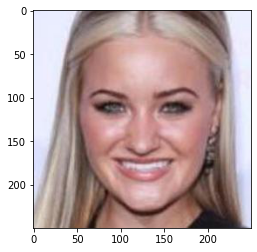

In [57]:
image_src1 = Image.open(source_batch[0])
plt.imshow(image_src1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


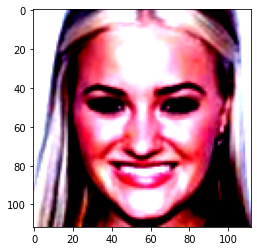

In [58]:
prepr_src = source_img_list[0]
prepr_src_img = helper_sq_transpose(prepr_src)
plt.imshow(prepr_src_img)

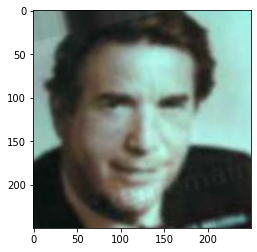

In [59]:
image_trg1 = Image.open(target_batch[0])
plt.imshow(image_trg1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


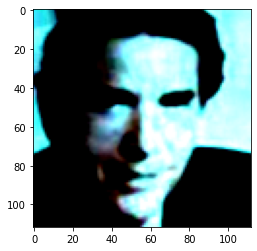

In [60]:
prepr_trg = target_img_list[0]
prepr_trg_img = helper_sq_transpose(prepr_trg)
plt.imshow(prepr_trg_img)

In [61]:
#average embeding from 5 traget.
net.eval()

target_embeding_list = []
for elem in target_img_list:
  target_embeding_list.append(net(elem))

average_target_embedings = torch.stack(target_embeding_list, dim=0).sum(0)/len(target_embeding_list)
print(average_target_embedings.shape) #torch.Size([5])


torch.Size([1, 512])


In [62]:
#source embeddings list
sorces_embeding_list = []
for elem in source_img_list:
 sorces_embeding_list.append(net(elem))

In [63]:
euclidian_list = []
for i in range(len(sorces_embeding_list)):
  euclidian_list.append(torch.dist(sorces_embeding_list[i],average_target_embedings))
print(euclidian_list)

[tensor(1.0509, grad_fn=<DistBackward>), tensor(1.0174, grad_fn=<DistBackward>), tensor(1.0616, grad_fn=<DistBackward>), tensor(1.0058, grad_fn=<DistBackward>), tensor(1.0022, grad_fn=<DistBackward>)]


In [64]:
#ATTACK

In [65]:
#SSIM must be 0.95 between attacked and original pics!!!!!! not between src and target.

In [92]:
original_src = source_img_list[1].clone()
attacked_src = source_img_list[1].clone()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


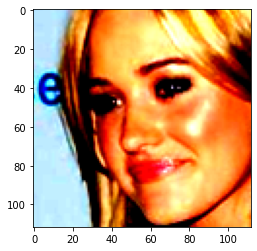

In [93]:
# prepr_src_img = helper_sq_transpose(test_src)
# print(prepr_src_img.shape)
plt.imshow(helper_sq_transpose(original_src))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


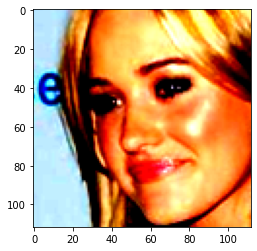

In [94]:
plt.imshow(helper_sq_transpose(attacked_src))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


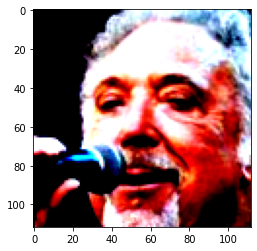

In [95]:
test_trg = target_img_list[2]
prepr_trg_img = helper_sq_transpose(test_trg)
plt.imshow(prepr_trg_img.squeeze(0))

In [96]:
ssim_atack_original = pytorch_ssim.ssim(original_src, attacked_src)
print("Initial ssim:", ssim_atack_original)

Initial ssim: tensor(1.)


In [97]:
start_dist = torch.dist(net(attacked_src), average_target_embedings,2)
#new_src_embed = src_embed
print(start_dist.item())
#must be 0

1.017392635345459


In [98]:
#custom loss function with two params
attack_src_emb = net(attacked_src)

emb_part_src = Variable(attack_src_emb,  requires_grad=True)
emb_part_target = Variable(average_target_embedings,  requires_grad =False)

img_part_attacked_src = Variable(attacked_src,requires_grad=True)
img_part_original_src = Variable(original_src,requires_grad=False)

loss_func = nn.MSELoss()
ssim_loss = pytorch_ssim.SSIM()
optimizer_emb = optim.Adam([img_part_attacked_src],lr=0.005)

loss_out_img_float = 1


cnt = 0
while loss_out_img_float >= 0.92:
    #cnt +=1
    optimizer_emb.zero_grad()
    loss_out_emb = loss_func(net(img_part_attacked_src), emb_part_target)
    loss_out_img = ssim_loss(img_part_attacked_src,img_part_original_src)
    total_loss_float = loss_out_emb.item()
    #print(total_loss_float,"Embed loss")
    loss_out_img_float = loss_out_img.item()
    print(loss_out_img_float,"Image loss")
    loss_out_emb.backward() 
    optimizer_emb.step()
    # if loss_out_img.item() <=0.95:
    #   break
    # if cnt==100:
    #   break
    

1.0 Image loss
0.9978728890419006 Image loss
0.9929767847061157 Image loss
0.9861088991165161 Image loss
0.9779198169708252 Image loss
0.9689306020736694 Image loss
0.9596163034439087 Image loss
0.9503688812255859 Image loss
0.9415332078933716 Image loss
0.9332526326179504 Image loss
0.9255971908569336 Image loss
0.918583869934082 Image loss


In [99]:
finish_dist = torch.dist(net(attacked_src), average_target_embedings,2)
#new_src_embed = src_embed
print(finish_dist.item())

0.466463565826416


In [100]:
ssim_atack_train = pytorch_ssim.ssim(original_src, attacked_src)
print("Initial ssim:", ssim_atack_train)

Initial ssim: tensor(0.9122)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


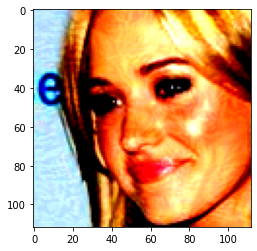

In [101]:
plt.imshow(helper_sq_transpose(attacked_src))

In [ ]:
# euclidian_list_final = []
# for i in range(len(sorces_embeding_list)):
#   euclidian_list.append(torch.dist(sorces_embeding_list[i],average_target_embedings))
# print(euclidian_list)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


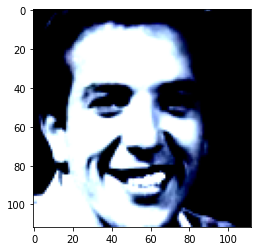

In [90]:
test_trg_other = target_img_list[3]
prepr_trg_img = helper_sq_transpose(test_trg_other)
plt.imshow(prepr_trg_img.squeeze(0))

In [91]:
finish_dist_other = torch.dist(net(attacked_src), net(test_trg_other),2)
#new_src_embed = src_embed
print(finish_dist_other.item())

0.6573778986930847
